#### Variant discovery in large multi-ancestry cohorts
This notebook explores the effect of sampling strategy for the discovery of (primarily rare) variants in large datasets.

Below, we'll simulate data using a simplified demographic history, including "European", "West African" and "African American" cohorts. This model very loosely follows that in [Tennessen et al (2012)](https://pubmed.ncbi.nlm.nih.gov/22604720/), with slightly updated parameters.

Software used:
- demes and demesdraw, [Gower et al (2012)](https://academic.oup.com/genetics/article-abstract/222/3/iyac131/6730747)
- msprime, [Baumdicker et al (2022)](https://academic.oup.com/genetics/article/220/3/iyab229/6460344)
- tskit, [Ralph et al (2020)](https://academic.oup.com/genetics/article/215/3/779/5930459)

In [1]:
import msprime
import tskit

import demes  # used for specifying demographic models
import demesdraw  # used for visualizing demographic models specified in demes

import numpy as np
import matplotlib.pylab as plt
import time

Quoting from the All of Us paper: "A total of 3,912,832 (99.98%) of the coding variants are rare (allelic frequency < 0.01) and the remaining 883 (0.02%) are common (allelic frequency > 0.01). Of the coding variants, 454 (0.01%) are common in one or more of the non-European computed ancestries in All of Us, rare among participants of European ancestry, and have an allelic number greater than 1,000."

In [2]:
# Demographic model specification
builder = demes.Builder(generation_time=29, time_units="years")
builder.add_deme(
    name="ancestral",
    epochs=[dict(start_size=10000, end_time=250000), dict(start_size=20000, end_time=75000)]
)
builder.add_deme(
    name="Eur",
    ancestors=["ancestral"],
    epochs=[dict(start_size=1000, end_time=25000),
            dict(end_size=20000, end_time=5000),
            dict(end_size=1000000, end_time=0)
           ]
)
builder.add_deme(
    name="Afr",
    ancestors=["ancestral"],
    epochs=[dict(start_size=20000, end_time=5000),
            dict(end_size=1000000, end_time=0)
           ]
)
builder.add_deme(
    name="Adm",
    ancestors=["Afr", "Eur"],
    proportions=[0.8, 0.2],
    start_time=15 * 29,  # 15 generations ago
    epochs=[dict(start_size=30000, end_size=1000000)]
)
builder.add_migration(demes=["Eur", "Afr"], rate=1e-4)
builder.add_migration(demes=["Eur", "Adm"], rate=1e-3)
graph = builder.resolve()

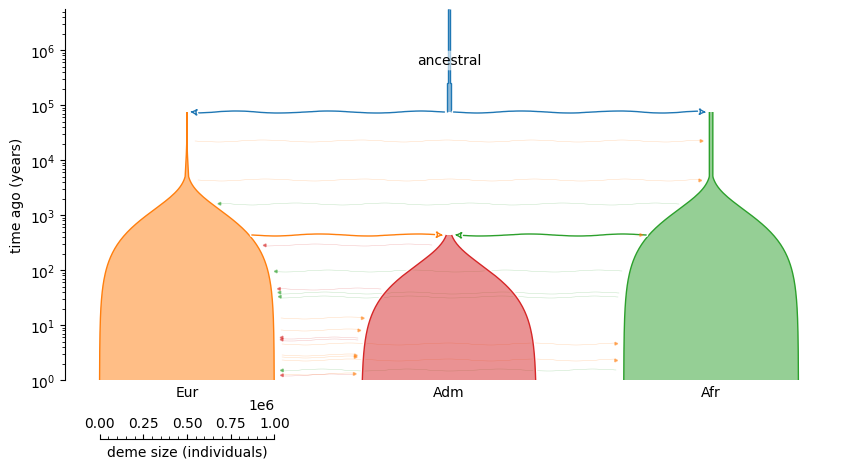

In [3]:
demesdraw.tubes(
    graph, log_time=True, scale_bar=True, num_lines_per_migration=5,
    positions={"Eur": -1.5e6, "Adm": 0, "Afr": 1.5e6, "ancestral": 0});

Let's say previous cohort composition was 50,000 European individuals. Now, we can sequence an extra 50,000 individuals - what's the difference in number of newly discovered variants between sequencing another 50,000 Europeans vs 50,000 Admixed individuals (Admixed group has ancestry proportions 80/20 from Afr and Eur, resp.).

A few questions: 1) How many new variants are discovered in those two scenarios? 2) What are their frequencies? 3) What variants do you miss in either of those choices?

#### Let's run the simulation

In [4]:
# samples include the first 50,000 plus an extra 50k from either Eur or Adm
samples = {"Eur": 100000, "Adm": 50000}

demog = msprime.Demography.from_demes(graph)
seed = 42

time1 = time.time()
ts = msprime.sim_ancestry(
    samples,
    demography=demog,
    sequence_length=1e6,
    recombination_rate=1e-8,
    model=[msprime.DiscreteTimeWrightFisher(duration=20), msprime.StandardCoalescent()],
    random_seed=seed,
)
time2 = time.time()
print("Simulation took", int(time2 - time1), "seconds")

Simulation took 82 seconds


In [5]:
# set discrete genome to False so that we deal just with biallelic sites
mut = msprime.sim_mutations(ts, rate=1e-8, random_seed=seed, discrete_genome=False)

In [6]:
print(mut)

╔═══════════════════════════╗
║TreeSequence               ║
╠═══════════════╤═══════════╣
║Trees          │      84354║
╟───────────────┼───────────╢
║Sequence Length│  1000000.0║
╟───────────────┼───────────╢
║Time Units     │generations║
╟───────────────┼───────────╢
║Sample Nodes   │     300000║
╟───────────────┼───────────╢
║Total Size     │   62.9 MiB║
╚═══════════════╧═══════════╝
╔═══════════╤══════╤═════════╤════════════╗
║Table      │Rows  │Size     │Has Metadata║
╠═══════════╪══════╪═════════╪════════════╣
║Edges      │937935│ 28.6 MiB│          No║
╟───────────┼──────┼─────────┼────────────╢
║Individuals│150000│  4.0 MiB│          No║
╟───────────┼──────┼─────────┼────────────╢
║Migrations │     0│  8 Bytes│          No║
╟───────────┼──────┼─────────┼────────────╢
║Mutations  │ 88597│  3.1 MiB│          No║
╟───────────┼──────┼─────────┼────────────╢
║Nodes      │669135│ 17.9 MiB│          No║
╟───────────┼──────┼─────────┼────────────╢
║Populations│     4│345 Bytes│        

In [227]:
print("Fst:", mut.Fst([range(200000), range(200000, 300000)]))

Fst: 0.08577407726351305


In [7]:
# Set up sample sets for cohorts of different sizes
samples_50k = range(2 * 50000)
samples_100kEur = range(2 * 100000)
samples_50kEach = np.concatenate((range(2 * 50000), range(2 * 100000, 2 * 150000)))

ts_50k = mut.simplify(samples_50k)
ts_100kEur = mut.simplify(samples_100kEur)
ts_50kEach = mut.simplify(samples_50kEach)

In [9]:
print("Num mutations in 50k cohort:", ts_50k.num_mutations)
print("Num mutations in 100k Eur cohort:", ts_100kEur.num_mutations)
print("Num mutations in 50k-each cohort:", ts_50kEach.num_mutations)

Num mutations in 50k cohort: 49357
Num mutations in 100k Eur cohort: 66547
Num mutations in 50k-each cohort: 72806


#### New variants in this simulation

As you'd expect, the multi-ancestry cohort contains more variants. But it's not hugely different.

In [10]:
print(f"Doubling the number of Eur individuals: {ts_100kEur.num_mutations-ts_50k.num_mutations} new variants")
print(f"Adding 50k samples from different ancestry: {ts_50kEach.num_mutations-ts_50k.num_mutations} new variants")

Doubling the number of Eur individuals: 17190 new variants
Adding 50k samples from different ancestry: 23449 new variants


But of these new variants, their frequencies among samples in each group will be quite different.

Of these newly discovered variants, what are their allele counts within each cohort?

To do this, we'll get the sites of previously known variants in the original 50k cohort, then in each expanded cohort sampling, we'll get the allele frequencies of the newly discovered variants.

In [11]:
# there is probably a much nicer way to do this within tskit (maybe even a built-in function?)
existing_variant_positions = np.zeros(ts_50k.num_mutations)
existing_allele_counts = np.zeros(ts_50k.num_mutations, dtype=int)
i = 0
for tree in ts_50k.trees():
    for m in tree.mutations():
        existing_variant_positions[i] = ts_50k.site(m.site).position
        existing_allele_counts[i] = tree.num_samples(m.node)
        i += 1
assert i == ts_50k.num_mutations

In [12]:
idx, counts = np.unique(existing_allele_counts, return_counts=True)
fs_50k = np.zeros(2 * 50000 + 1)
fs_50k[idx] = counts

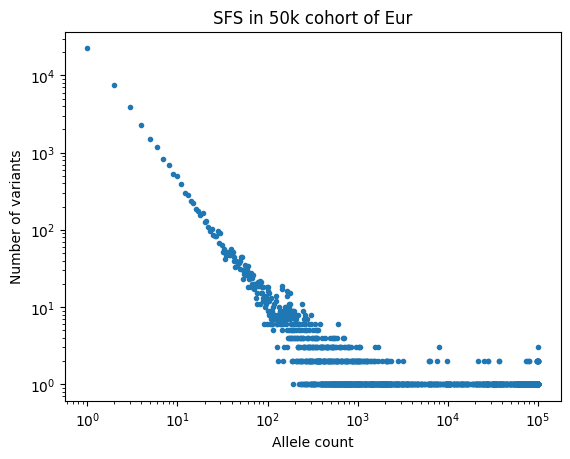

In [13]:
plt.plot(fs_50k, ".")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Allele count")
plt.ylabel("Number of variants")
plt.title("SFS in 50k cohort of Eur");

Of new variants discovered in the expanded sampling, what are their frequencies in each group?

In [14]:
# get positions of the newly discovered variants

new_100k_eur = []
new_50k_each = []

for tree in ts_100kEur.trees():
    for m in tree.mutations():
        pos = ts_100kEur.site(m.site).position
        if pos not in existing_variant_positions:
            new_100k_eur.append(pos)

for tree in ts_50kEach.trees():
    for m in tree.mutations():
        pos = ts_50kEach.site(m.site).position
        if pos not in existing_variant_positions:
            new_50k_each.append(pos)


In [15]:
# what are their frequencies in the larger sampled data (100,000 and 50,000, resp)

acs_100k_eur = np.zeros((len(new_100k_eur), 2), dtype=int)
acs_50k_each = np.zeros((len(new_50k_each), 2), dtype=int)

i1 = 0
i2 = 0
for tree in mut.trees():
    for m in tree.mutations():
        pos = mut.site(m.site).position
        if pos in existing_variant_positions:
            continue
        # get allele counts of the mutation
        sample_nodes = np.array(list(tree.samples(m.node)))
        ac = [sum(sample_nodes < 2 * 100000), sum(sample_nodes >= 2 * 100000)]
        # check which dataset the new variant is discovered in
        if pos in new_100k_eur:
            acs_100k_eur[i1] = ac
            i1 += 1
        if pos in new_50k_each:
            acs_50k_each[i2] = ac
            i2 += 1

In [16]:
# SFS of new variants from 100k Eur cohort in Eur individuals
inds, cs = np.unique(acs_100k_eur[:, 0], return_counts=True)
fs1_eur = np.zeros(2 * 100000 + 1)
fs1_eur[inds] = cs
# SFS of new variants from 100k Eur cohort in Adm individuals
inds, cs = np.unique(acs_100k_eur[:, 1], return_counts=True)
fs1_adm = np.zeros(2 * 50000 + 1)
fs1_adm[inds] = cs

In [17]:
# SFS of new variants from 50k-each cohort in Eur individuals
inds, cs = np.unique(acs_50k_each[:, 0], return_counts=True)
fs2_eur = np.zeros(2 * 100000 + 1)
fs2_eur[inds] = cs
# SFS of new variants from 100k Eur cohort in Adm individuals
inds, cs = np.unique(acs_50k_each[:, 1], return_counts=True)
fs2_adm = np.zeros(2 * 50000 + 1)
fs2_adm[inds] = cs

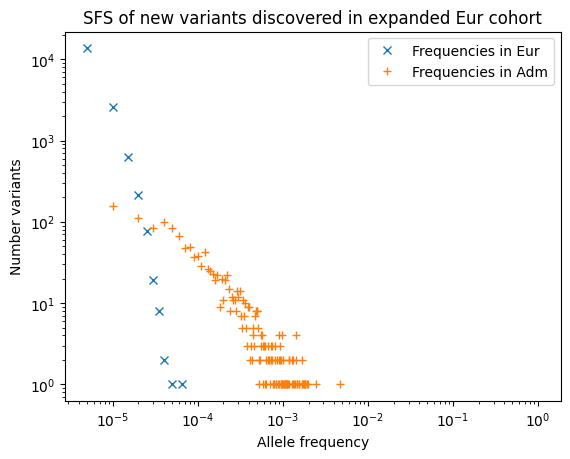

In [18]:
plt.plot(np.linspace(0, 1, 200001)[1:-1], fs1_eur[1:-1], "x", label="Frequencies in Eur")
plt.plot(np.linspace(0, 1, 100001)[1:-1], fs1_adm[1:-1], "+", label="Frequencies in Adm")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.title("SFS of new variants discovered in expanded Eur cohort")
plt.xlabel("Allele frequency")
plt.ylabel("Number variants");

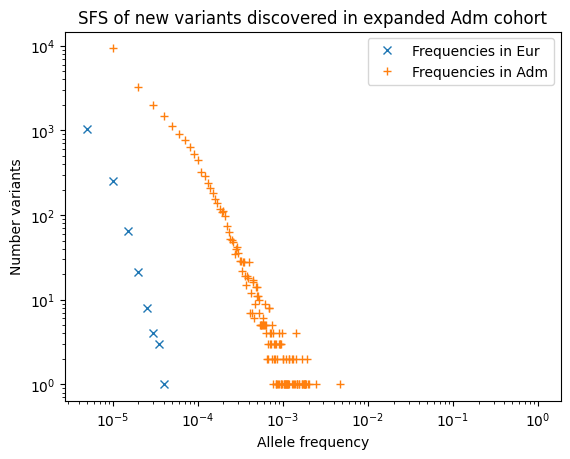

In [19]:
plt.plot(np.linspace(0, 1, 200001)[1:-1], fs2_eur[1:-1], "x", label="Frequencies in Eur")
plt.plot(np.linspace(0, 1, 100001)[1:-1], fs2_adm[1:-1], "+", label="Frequencies in Adm")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.title("SFS of new variants discovered in expanded Adm cohort")
plt.xlabel("Allele frequency")
plt.ylabel("Number variants");

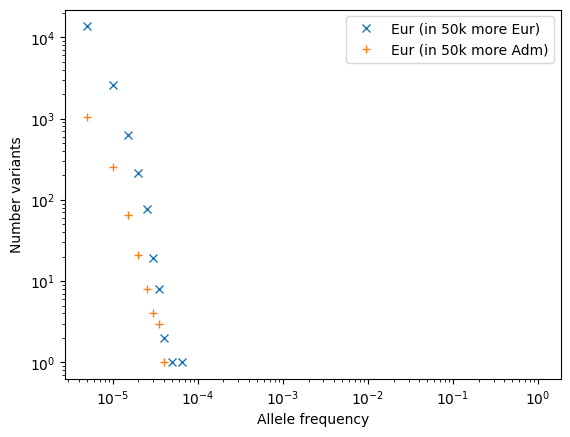

In [20]:
plt.plot(np.linspace(0, 1, 200001)[1:-1], fs1_eur[1:-1], "x", label="Eur (in 50k more Eur)")
plt.plot(np.linspace(0, 1, 200001)[1:-1], fs2_eur[1:-1], "+", label="Eur (in 50k more Adm)")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.xlabel("Allele frequency")
plt.ylabel("Number variants");

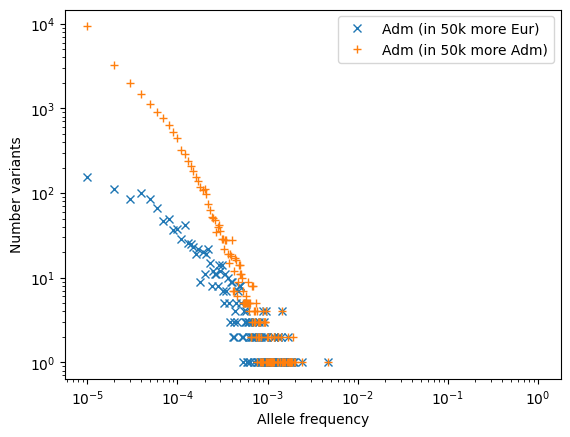

In [21]:
plt.plot(np.linspace(0, 1, 100001)[1:-1], fs1_adm[1:-1], "x", label="Adm (in 50k more Eur)")
plt.plot(np.linspace(0, 1, 100001)[1:-1], fs2_adm[1:-1], "+", label="Adm (in 50k more Adm)")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.xlabel("Allele frequency")
plt.ylabel("Number variants");

In [22]:
# SFS of new variants from 100k Eur cohort in all individuals
inds, cs = np.unique(np.sum(acs_100k_eur, axis=1), return_counts=True)
fs1_all = np.zeros(2 * 150000 + 1)
fs1_all[inds] = cs
# SFS of new variants from 50k each cohort in all individuals
inds, cs = np.unique(np.sum(acs_50k_each, axis=1), return_counts=True)
fs2_all = np.zeros(2 * 150000 + 1)
fs2_all[inds] = cs

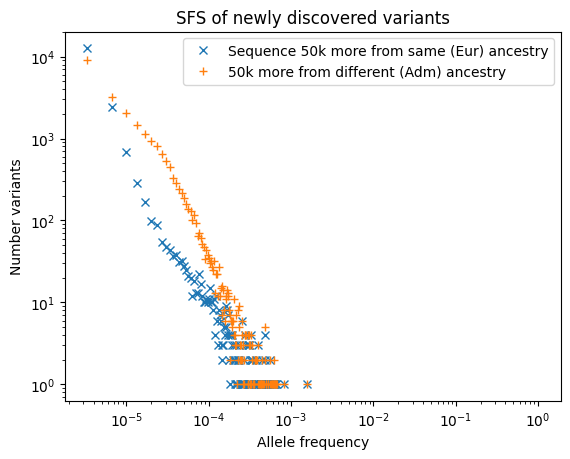

In [23]:
plt.plot(np.linspace(0, 1, 300001)[1:-1], fs1_all[1:-1], "x", label="Sequence 50k more from same (Eur) ancestry")
plt.plot(np.linspace(0, 1, 300001)[1:-1], fs2_all[1:-1], "+", label="50k more from different (Adm) ancestry")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.title("SFS of newly discovered variants")
plt.xlabel("Allele frequency")
plt.ylabel("Number variants");

In [26]:
# all variants, vs excluding singletons, doubletons and tripletons
print("All, No singletons, Count > 2, Count > 3")
print("Sampling from Eur:")
print(fs1_all.sum(), fs1_all[1:].sum(), fs1_all[2:].sum(), fs1_all[3:].sum())
print("Sampling from Adm:")
print(fs2_all.sum(), fs2_all[1:].sum(), fs2_all[2:].sum(), fs2_all[3:].sum())

All, No singletons, Count > 2, Count > 3
Sampling from Eur:
17190.0 17190.0 4580.0 2146.0
Sampling from Adm:
23449.0 23449.0 14284.0 11063.0
